In [1]:
# %%
import sys
sys.path.append('/workspace/Documents/')
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import glob as gb
import nibabel as nb 
import math
import pandas as pd
import os
import copy
from skimage.measure import block_reduce
import ct_basic as ct

import Diffusion_denoising_thin_slice.functions_collection as ff
import Diffusion_denoising_thin_slice.Data_processing as Data_processing

import ct_projector.projector.cupy as ct_projector
import CTProjector.src.ct_projector.projector.cupy as ct_projector
import CTProjector.src.ct_projector.projector.cupy.fan_equiangular as ct_fan 
import CTProjector.src.ct_projector.projector.numpy as numpy_projector
import CTProjector.src.ct_projector.projector.numpy.fan_equiangluar as numpy_fan
main_path = '/mnt/camca_NAS/denoising/Data'

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
patient_sheet = pd.read_excel(os.path.join('/mnt/camca_NAS/denoising/','Patient_lists', 'fixedCT_static.xlsx'),dtype={'Patient_ID': str, 'Patient_subID': str})
print('patient sheet len: ', len(patient_sheet))

for i in range(0, len(patient_sheet)):
    row = patient_sheet.iloc[i]
    patient_id = row['Patient_ID']
    patient_subID = row['Patient_subID']
    if patient_id != '00214841':
        continue
    print('patient_id: ', patient_id, 'patient_subID: ', patient_subID)

    save_folder_case = os.path.join(main_path,'simulation', patient_id,patient_subID)
    os.makedirs(os.path.dirname(save_folder_case), exist_ok=True)
    os.makedirs(save_folder_case, exist_ok=True)

    # set dose factor
    gaussian_custom_dose_range = [0.085,0.1]
    dose_factor = np.random.uniform(gaussian_custom_dose_range[0],gaussian_custom_dose_range[1] + 1e-8)

    print('dose factor: ', dose_factor)

    cp.cuda.Device(0).use()
    ct_projector.set_device(0)

    # img file
    img_file = os.path.join(main_path,'fixedCT',patient_id,patient_subID,'img_thinslice.nii.gz')

    # load img
    img,spacing,img_affine = ct.basic_image_processing(img_file)
    # print('img shape, min, max: ', img.shape, np.min(img), np.max(img))
    # print('spacing: ', spacing)

    # define projectors
    img = img[np.newaxis, ...]
    print('image shape: ', img.shape)
    projector = ct.define_forward_projector(img,spacing,total_view = 1440, file_name = './projector_fan_neuro.cfg')
    fbp_projector = ct.backprojector(img,spacing)
    print('projector nu:', projector.nu)

    # forward projection
    angles = ct.get_angles_zc(1440, 360 ,0)
    proj = ct.fp_static(img,angles,projector, geometry = 'fan')

    # add noise
    proj_noise = ct.add_gaussian_noise(proj, N0=1000000, dose_factor=dose_factor) - proj

    # reconstruciton - FBP
    cuangles = cp.array(angles, cp.float32, order = 'C')
    # process the kernel
    custom_filter = np.fromfile(os.path.join('/mnt/camca_NAS/denoising/Data', 'softTissueKernel_65'), np.float32)
    filter_len = 2048
    new_filter = custom_filter[:len(custom_filter) // 2]
    
    custom_filter = np.zeros([filter_len], np.float32)
    custom_filter[:len(new_filter)] = new_filter
    custom_filter[len(custom_filter) // 2:] = custom_filter[len(custom_filter) // 2:0:-1]
    
    proj_noise_copy = np.copy(proj_noise, 'C')
   
    fprjs = np.fft.fft(proj_noise_copy, len(custom_filter), axis=-1)
    fprjs = fprjs * custom_filter
    fprjs = np.fft.ifft(fprjs, axis=-1)[..., :proj_noise_copy.shape[-1]]
    fprjs = fprjs.real.astype(np.float32) * np.pi / len(custom_filter) / 2
    fprj_noise = np.copy(fprjs, 'C')

    # fbp the noise
    projector.set_backprojector(ct_fan.distance_driven_bp, angles=cuangles, is_fbp=True) 
    cufprj_noise= cp.array(fprj_noise, cp.float32, order = 'C')
    curecon_noise = projector.bp(cufprj_noise)
    recon_noise = curecon_noise.get()
    recon_noise = recon_noise[:,0,...]

    # add noise to original img
    recon = recon_noise + img[0,...]
    recon = recon /0.019 * 1000 - 1024
    recon_noise = recon_noise /0.019 * 1000 


    save_folder = os.path.join(save_folder_case, 'trial')
    ff.make_folder([save_folder])
    # save recon
    recon_nb_image = np.rollaxis(recon,0,3)
    nb.save(nb.Nifti1Image(recon_nb_image,img_affine), os.path.join(save_folder,'recon.nii.gz'))

patient sheet len:  100
patient_id:  00214841 patient_subID:  0000455418
dose factor:  0.09654522458800929
image shape:  (1, 140, 512, 512)
projector nu: 448


KeyboardInterrupt: 

In [2]:
main_path = '/mnt/camca_NAS/denoising/Data'

# define the patient list
patient_sheet = pd.read_excel(os.path.join('/mnt/camca_NAS/denoising/','Patient_lists', 'fixedCT_static.xlsx'),dtype={'Patient_ID': str, 'Patient_subID': str})
print('patient sheet len: ', len(patient_sheet))

row = patient_sheet.iloc[0]
patient_id = row['Patient_ID']
patient_subID = row['Patient_subID']

print(patient_id, patient_subID)

save_folder_case = os.path.join(main_path,'simulation', patient_id,patient_subID)
ff.make_folder([os.path.dirname(save_folder_case), save_folder_case])

patient sheet len:  100
00214938 0000455723


In [4]:
cp.cuda.Device(0).use()
ct_projector.set_device(0)

# img file
img_file = os.path.join(main_path,'fixedCT',patient_id,patient_subID,'img_thinslice.nii.gz')

# load img
img,spacing,img_affine = ct.basic_image_processing(img_file)
print('img shape, min, max: ', img.shape, np.min(img), np.max(img))
print('spacing: ', spacing)

# define projectors
img = img[np.newaxis, ...]
print('image shape: ', img.shape)
projector = ct.define_forward_projector(img,spacing,total_view = 1440)
fbp_projector = ct.backprojector(img,spacing)

# FP
# set angles
angles = ct.get_angles_zc(1400, 360 ,0)
proj = ct.fp_static(img,angles,projector, geometry = 'fan')

# add noise
proj_noise = ct.add_poisson_noise(proj, N0=1000000, dose_factor=0.2) - proj

img shape, min, max:  (148, 512, 512) 1.159668e-09 0.0548093
spacing:  [1.25       0.48046875 0.48046875]
image shape:  (1, 148, 512, 512)


In [ ]:
import scipy
custom_filter = np.fromfile(os.path.join('/mnt/camca_NAS/denoising/Data', 'softTissueKernel_65'), np.float32)

filter_len = 2048

new_filter = custom_filter[:len(custom_filter) // 2]
new_filter = scipy.ndimage.zoom(new_filter, 1, order=1)
custom_filter = np.zeros([filter_len], np.float32)
custom_filter[:len(new_filter)] = new_filter
custom_filter[len(custom_filter) // 2:] = custom_filter[len(custom_filter) // 2:0:-1]
plt.plot(custom_filter)

(2048,)
(148, 1400, 1, 736)
736 0.43868008255958557


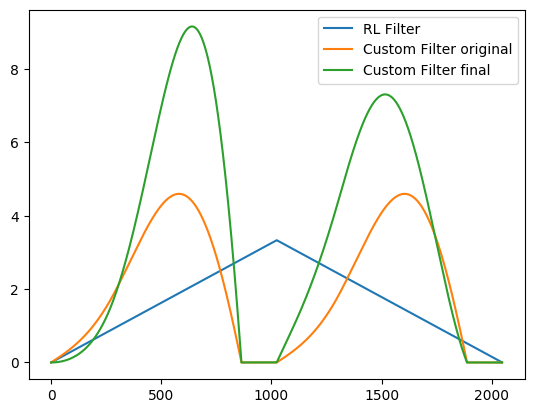

In [8]:
# # load custom filter
# custom_filter = np.fromfile(os.path.join('/mnt/camca_NAS/denoising/Data', '6x5_Bone'), np.float32)
# print(custom_filter.shape)
# nu = proj_noise.shape[-1]
# print(proj_noise.shape)
# du = projector.du
# print(nu, du)

# rl_filter = np.zeros([2 * nu - 1], np.float32)
# k = np.arange(len(rl_filter)) - (nu - 1)
# for i in range(len(rl_filter)):
#     if k[i] == 0:
#         rl_filter[i] = 1 / (4 * du * du)
#     elif k[i] % 2 != 0:
#         rl_filter[i] = -1 / (np.pi * np.pi * k[i] * k[i] * du * du)
# frl_filter = np.fft.fft(rl_filter, len(custom_filter))
# frl_filter = np.abs(frl_filter)

# frl_filter = frl_filter * len(frl_filter) / proj_noise.shape[1] * du * 2

# custom_filter_final = frl_filter * custom_filter

# plt.figure()
# plt.plot(frl_filter, label="RL Filter")
# plt.plot(custom_filter, label="Custom Filter original")
# plt.plot(custom_filter_final, label="Custom Filter final")

# plt.legend()
# plt.show()

(2048,)
(148, 1400, 1, 736)
736 0.43868008255958557


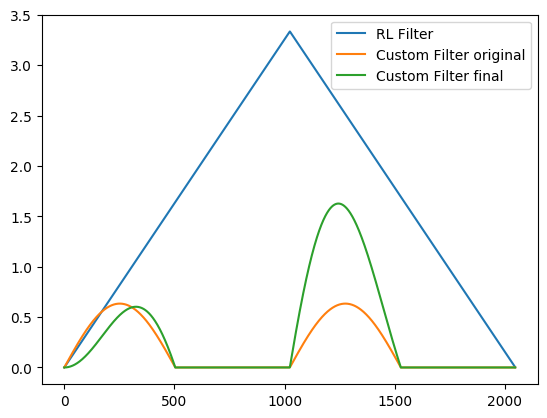

In [7]:
# # load custom filter
# custom_filter = np.fromfile(os.path.join('/mnt/camca_NAS/denoising/Data', 'softTissueKernel_65'), np.float32)
# print(custom_filter.shape)
# nu = proj_noise.shape[-1]
# print(proj_noise.shape)
# du = projector.du
# print(nu, du)

# rl_filter = np.zeros([2 * nu - 1], np.float32)
# k = np.arange(len(rl_filter)) - (nu - 1)
# for i in range(len(rl_filter)):
#     if k[i] == 0:
#         rl_filter[i] = 1 / (4 * du * du)
#     elif k[i] % 2 != 0:
#         rl_filter[i] = -1 / (np.pi * np.pi * k[i] * k[i] * du * du)
# frl_filter = np.fft.fft(rl_filter, len(custom_filter))
# frl_filter = np.abs(frl_filter)

# frl_filter = frl_filter * len(frl_filter) / proj_noise.shape[1] * du * 2

# custom_filter_final = frl_filter * custom_filter

# plt.figure()
# plt.plot(frl_filter, label="RL Filter")
# plt.plot(custom_filter, label="Custom Filter original")
# plt.plot(custom_filter_final, label="Custom Filter final")

# plt.legend()
# plt.show()


In [20]:
# apply filter
proj_noise_copy = np.copy(proj_noise, 'C')
   
fprjs = np.fft.fft(proj_noise_copy, len(custom_filter_final), axis=-1)
fprjs = fprjs * custom_filter_final
fprjs = np.fft.ifft(fprjs, axis=-1)[..., :proj_noise_copy.shape[-1]]
fprjs = fprjs.real.astype(np.float32) * np.pi / len(custom_filter_final) / 2
fprj_noise = np.copy(fprjs, 'C')

In [21]:
cuangles = cp.array(angles, cp.float32, order = 'C')
projector.set_backprojector(ct_fan.distance_driven_bp, angles=cuangles, is_fbp=True) 
    
cufprj_noise= cp.array(fprj_noise, cp.float32, order = 'C')
curecon_noise = projector.bp(cufprj_noise)
recon_noise = curecon_noise.get()
recon_noise = recon_noise[:,0,...]

# add original img
# recon_noise = recon_noise /0.019 * 1000 - 1024 
# recon_original = img[0,...] /0.019 * 1000 - 1024
recon = recon_noise + img[0,...]
recon = recon /0.019 * 1000 - 1024
recon_noise = recon_noise /0.019 * 1000 


save_folder = os.path.join(save_folder_case, 'try2')
ff.make_folder([save_folder])

# save recon
recon_nb_image = np.rollaxis(recon,0,3)
nb.save(nb.Nifti1Image(recon_nb_image,img_affine), os.path.join(save_folder,'recon.nii.gz'))
recon_noise_image = np.rollaxis(recon_noise,0,3)
nb.save(nb.Nifti1Image(recon_noise_image,img_affine), os.path.join(save_folder,'recon_noise.nii.gz'))
recon_original_image = recon_nb_image - recon_noise_image
nb.save(nb.Nifti1Image(recon_original_image,img_affine), os.path.join(save_folder,'recon_original.nii.gz'))
        